# Read Data

In [1]:
import pandas as pd
# Read the CSVs
footbridge = pd.read_csv('Creek Data/footbridge.csv')

grinnel=pd.read_csv('Creek Data/grinnel.csv')

lbnl_2021_2023=pd.read_csv('lbnl data/LBNL1 Weather Data 2021-2023.csv')

 'BaroPres','DeltaTemp_Avg', 'Dew_Pt_Avg','PanelTmpF_Avg', 'Precip_Tot 'RelHum_Avg''SolRad_Avg'    'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg',  'VertWind_Avg', 'VertWind_Max', 'WindGust_Max', 'WndDir', 'WndDir_res',
       'WndSpd', 'WndSpd_dup', 'WndSpd_res''Temp2m_Avg'

# add rain data from open lbnl

In [2]:
import pandas as pd
import numpy as np
# The 'requests' library is no longer needed

# ===================================================================
#  1. HELPER FUNCTION DEFINITIONS
# ===================================================================

def clean_column_names(df):
    """
    Cleans, standardizes, and consolidates messy sensor column names in a DataFrame.
    (This function remains unchanged)
    """
    rename_map = {}
    name_patterns = {
        'datetime': 'Monitoring Date', 'temperature': 'Temp', 'depth': 'Depth',
        'conductivity': 'Cond', 'battery': 'Batt', 'signal_percent': 'SignalPercent'
    }
    for old_name in df.columns:
        for new_name, pattern in name_patterns.items():
            if pattern in old_name:
                rename_map[old_name] = new_name
                break
    df.rename(columns=rename_map, inplace=True)
    unique_renamed_cols = set(rename_map.values())
    for name in unique_renamed_cols:
        if df.columns.tolist().count(name) > 1:
            dup_cols_df = df.loc[:, df.columns == name]
            consolidated_series = dup_cols_df.bfill(axis=1).iloc[:, 0]
            df.drop(columns=[name], inplace=True)
            df[name] = consolidated_series

## NEW HELPER FUNCTION ##
def prepare_lbnl_weather_data(lbnl_df):
    """
    Selects required columns from the LBNL weather data, renames the timestamp,
    and prepares it for merging.
    """
    # Define the columns you want to keep from the LBNL dataset
    columns_to_keep = [
        'Timestamp (UTC-8)', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg',
        'Precip_Tot', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg',
        'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max',
        'WndDir', 'WndDir_res', 'WndSpd', 'WndSpd_dup', 'WndSpd_res', 'SolRad_Avg'
    ]

    # Filter for the columns we need
    weather_df = lbnl_df[columns_to_keep].copy()

    # Rename columns for consistency and merging
    weather_df.rename(columns={
        'Timestamp (UTC-8)': 'datetime',
        'Precip_Tot': 'rain_mm'  # Renaming for compatibility with plotting functions
    }, inplace=True)

    # Ensure the datetime column is the correct data type
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

    # Sort by datetime, which is required for merge_asof
    weather_df.sort_values('datetime', inplace=True)

    return weather_df

# ===================================================================
#  2. MAIN PROCESSING FUNCTION (MODIFIED)
# ===================================================================

## MODIFIED MAIN FUNCTION ##
def create_final_dataset(file_path_map, lbnl_weather_df):
    """
    Loads, cleans, and combines sensor data, then merges it with the
    provided LBNL weather DataFrame.
    """
    all_sensors_list = []
    print("Loading and cleaning sensor data files...")
    for name, path in file_path_map.items():
        df = pd.read_csv(path)
        clean_column_names(df)
        df['location'] = name
        all_sensors_list.append(df)

    # --- Combine and consolidate the cleaned sensor data ---
    all_data = pd.concat(all_sensors_list, ignore_index=True)
    all_data['datetime'] = pd.to_datetime(all_data['datetime'], errors='coerce')
    all_data.dropna(subset=['datetime'], inplace=True)
    all_data.replace(-9999.0, np.nan, inplace=True)

    # --- Prepare the local LBNL weather data ---
    print("Preparing LBNL weather data... ☀️")
    weather_df = prepare_lbnl_weather_data(lbnl_weather_df)

    # --- Merge sensor data with the nearest LBNL weather measurement ---
    print("Merging weather data... 🔗")
    all_data = all_data.sort_values('datetime')
    # Use merge_asof to find the closest weather station reading for each sensor reading
    final_df = pd.merge_asof(all_data, weather_df, on='datetime', direction='nearest')

    print("Process complete!")
    return final_df

# ===================================================================
#  3. RUN THE WORKFLOW
# ===================================================================

# --- Step 1: Define the paths to your creek data files ---
# !!! This dictionary should still point to your creek sensor files !!!
file_paths = {
    'grinnel': 'Creek Data/grinnel.csv',
    'footbridge': 'Creek Data/footbridge.csv'
}

# --- Step 2: Run the main function with the LBNL DataFrame ---
# !!! Ensure your 'lbnl_2021_2023' DataFrame is loaded before this step !!!
# For example:
# lbnl_2021_2023 = pd.read_csv('path/to/your/lbnl_data.csv')

final_df_MMW_lbnl = create_final_dataset(file_paths, lbnl_2021_2023)

# --- Step 3: Display the result ---



final_df_MMW_lbnl

Loading and cleaning sensor data files...
Preparing LBNL weather data... ☀️
Merging weather data... 🔗
Process complete!


,datetime,conductivity,signal_percent,depth,battery,temperature,location,BaroPres,DeltaTemp_Avg,Dew_Pt_Avg,...,Temp2m_Avg,VertWind_Avg,VertWind_Max,WindGust_Max,WndDir,WndDir_res,WndSpd,WndSpd_dup,WndSpd_res,SolRad_Avg
0,2021-04-30 14:50:00,0.0,90.0,-3.5,4.291,27.75,footbridge,987.4875,-5.088,47.72,...,61.86,0.0,0.0,8.17,230.80,231.80,4.280,4.280,3.785,714.40
1,2021-04-30 14:55:00,0.0,51.0,-3.3,4.230,27.75,footbridge,987.4875,-5.388,47.79,...,63.08,0.0,0.0,8.02,206.20,209.50,3.151,3.151,2.411,679.70
2,2021-04-30 15:00:00,0.0,90.0,-3.7,4.230,27.50,footbridge,987.4875,-5.388,47.79,...,63.08,0.0,0.0,8.02,206.20,209.50,3.151,3.151,2.411,679.70
3,2021-04-30 17:35:00,26.5,NaN,0.0,23.900,10.50,grinnel,986.4113,-2.518,47.16,...,54.88,0.0,0.0,11.07,228.50,228.40,5.911,5.911,5.614,159.00
4,2021-04-30 18:00:00,26.5,NaN,0.0,23.900,10.20,grinnel,986.4538,-1.601,47.21,...,52.79,0.0,0.0,10.99,227.10,226.90,5.511,5.511,5.228,74.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387023,2025-08-09 15:00:00,356.0,84.0,435.3,4.397,45.50,footbridge,987.4055,0.467,45.77,...,49.27,0.0,0.0,15.42,70.53,69.05,5.286,5.286,4.897,0.00
387024,2025-08-09 15:15:00,346.5,84.0,436.8,4.397,45.00,footbridge,987.4055,0.467,45.77,...,49.27,0.0,0.0,15.42,70.53,69.05,5.286,5.286,4.897,0.00
387025,2025-08-09 15:30:00,334.0,81.0,433.0,4.260,44.50,footbridge,987.4055,0.467,45.77,...,49.27,0.0,0.0,15.42,70.53,69.05,5.286,5.286,4.897,0.00
387026,2025-08-09 15:45:00,326.8,84.0,437.5,4.260,44.00,footbridge,987.4055,0.467,45.77,...,49.27,0.0,0.0,15.42,70.53,69.05,5.286,5.286,4.897,0.00


# add rain data from open metreo 

In [3]:
import pandas as pd
import numpy as np
import requests
import re

# ===================================================================
#  1. HELPER FUNCTION DEFINITIONS
# ===================================================================

def clean_column_names(df):
    """
    Cleans, standardizes, and consolidates messy sensor column names in a DataFrame.
    This version correctly handles and merges duplicate columns (e.g., two temp sensors).
    """
    rename_map = {}
    name_patterns = {
        'datetime': 'Monitoring Date', 'temperature': 'Temp', 'depth': 'Depth',
        'conductivity': 'Cond', 'battery': 'Batt', 'signal_percent': 'SignalPercent'
    }

    # First, create a map of old names to new, simple names
    for old_name in df.columns:
        for new_name, pattern in name_patterns.items():
            if pattern in old_name:
                rename_map[old_name] = new_name
                break
    
    # Rename the columns. This step may create duplicate column names.
    df.rename(columns=rename_map, inplace=True)

    # Now, find and consolidate the duplicates
    unique_renamed_cols = set(rename_map.values())
    for name in unique_renamed_cols:
        # Check if any column name was created more than once
        if df.columns.tolist().count(name) > 1:
            # Select all columns with the same duplicate name
            dup_cols_df = df.loc[:, df.columns == name]
            
            # Consolidate them into a single series
            consolidated_series = dup_cols_df.bfill(axis=1).iloc[:, 0]
            
            # Drop all columns with the duplicate name from the original dataframe
            df.drop(columns=[name], inplace=True)
            
            # Add the single, consolidated series back
            df[name] = consolidated_series

def get_openmeteo_rain(lat, lon, start, end):
    """Fetches hourly precipitation for a given location and date range."""
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat, "longitude": lon, "start_date": start, "end_date": end,
        "hourly": "precipitation", "timezone": "auto"
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()
    df = pd.DataFrame({
        "datetime": pd.to_datetime(data["hourly"]["time"]),
        "rain_mm": data["hourly"]["precipitation"]
    })
    return df

# ===================================================================
#  2. MAIN PROCESSING FUNCTION
# ===================================================================

def create_final_dataset(file_path_map, lat=37.87, lon=-122.27):
    """
    Loads, cleans, combines, and merges sensor data with rain data.
    """
    all_sensors_list = []
    print("Loading and cleaning sensor data files...")
    for name, path in file_path_map.items():
        # Load the data
        df = pd.read_csv(path)
        # Clean the column names
        clean_column_names(df)
        # Add the location identifier
        df['location'] = name
        all_sensors_list.append(df)
    
    # --- Combine and consolidate the cleaned sensor data ---
    all_data = pd.concat(all_sensors_list, ignore_index=True)
    all_data['datetime'] = pd.to_datetime(all_data['datetime'], errors='coerce')
    all_data.dropna(subset=['datetime'], inplace=True)
    all_data.replace(-9999.0, np.nan, inplace=True)
    
    # --- Fetch rain data for the entire date range of the sensor data ---
    min_year = all_data['datetime'].min().year
    max_year = all_data['datetime'].max().year
    today = pd.Timestamp.now().date()
    
    print(f"Fetching rain data from {min_year} to {max_year}... 🌦️")
    all_rain_list = []
    for year in range(min_year, max_year + 1):
        start_date, end_date = f"{year}-01-01", f"{year}-12-31"
        if year == today.year:
            end_date = today.strftime('%Y-%m-%d')
        rain_year_df = get_openmeteo_rain(lat, lon, start_date, end_date)
        all_rain_list.append(rain_year_df)
    rain_df = pd.concat(all_rain_list, ignore_index=True)
    
    # --- Merge sensor data with the nearest rain measurement ---
    print("Merging rain data... 🔗")
    all_data = all_data.sort_values('datetime')
    rain_df = rain_df.sort_values('datetime')
    final_df = pd.merge_asof(all_data, rain_df, on='datetime', direction='nearest')
    
    print("Process complete!")
    return final_df

# ===================================================================
#  3. RUN THE WORKFLOW
# ===================================================================

# --- Step 1: Define the paths to your data files ---
# !!! EDIT THIS DICTIONARY WITH YOUR FILE PATHS !!!
file_paths = {
    'grinnel': 'Creek Data/grinnel.csv',
    'footbridge': 'Creek Data/footbridge.csv'
}

# --- Step 2: Run the main function to get your final DataFrame ---
final_df_MMW_metreo= create_final_dataset(file_paths)
final_df_MMW_metreo

Loading and cleaning sensor data files...
Fetching rain data from 2021 to 2025... 🌦️
Merging rain data... 🔗
Process complete!


,datetime,conductivity,signal_percent,depth,battery,temperature,location,rain_mm
0,2021-04-30 14:50:00,0.0,90.0,-3.5,4.291,27.75,footbridge,0.0
1,2021-04-30 14:55:00,0.0,51.0,-3.3,4.230,27.75,footbridge,0.0
2,2021-04-30 15:00:00,0.0,90.0,-3.7,4.230,27.50,footbridge,0.0
3,2021-04-30 17:35:00,26.5,NaN,0.0,23.900,10.50,grinnel,0.0
4,2021-04-30 18:00:00,26.5,NaN,0.0,23.900,10.20,grinnel,0.0
...,...,...,...,...,...,...,...,...
387023,2025-08-09 15:00:00,356.0,84.0,435.3,4.397,45.50,footbridge,0.0
387024,2025-08-09 15:15:00,346.5,84.0,436.8,4.397,45.00,footbridge,0.0
387025,2025-08-09 15:30:00,334.0,81.0,433.0,4.260,44.50,footbridge,0.0
387026,2025-08-09 15:45:00,326.8,84.0,437.5,4.260,44.00,footbridge,0.0


# Choose max rain values from lbnl and open metroe

In [4]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def combine_and_select_best_rain(meteo_df, lbnl_df):
    """
    Combines two DataFrames, ensuring all LBNL weather columns are retained.
    It converts LBNL rain from inches to mm, compares rain values from both
    sources, and keeps the greater value for each event.

    Args:
        meteo_df (pd.DataFrame): DataFrame with creek sensor and Open-Meteo data.
        lbnl_df (pd.DataFrame): DataFrame with creek sensor and LBNL weather data.

    Returns:
        pd.DataFrame: A single, consolidated DataFrame with the best rain data
                      and all LBNL weather columns.
    """
    print("🚀 Starting the combination process...")

    # --- Step 1: Work with copies ---
    meteo_copy = meteo_df.copy()
    lbnl_copy = lbnl_df.copy()

    # --- Step 2: Standardize LBNL Rain Units ---
    # Overwrite the 'rain_mm' column in the LBNL copy with corrected millimeter values.
    # IMPORTANT: Assumes the 'rain_mm' column in the LBNL frame initially holds INCH values.
    print("Converting LBNL rain data from inches to millimeters...")
    lbnl_copy['rain_mm'] = lbnl_copy['rain_mm'] * 25.4

    # --- Step 3: Merge Full DataFrames ---
    # Merge the two complete DataFrames. Pandas will automatically create suffixed
    # columns for any columns that exist in both (e.g., 'rain_mm_meteo', 'rain_mm_lbnl').
    print("Merging the full datasets to include all LBNL columns...")
    merged_df = pd.merge(
        meteo_copy,
        lbnl_copy,
        on=['datetime', 'location'],
        how='outer', # 'outer' merge keeps all rows from both frames
        suffixes=('_meteo', '_lbnl')
    )

    # --- Step 4: Combine Rain Data (Select Max) ---
    # Fill NaNs with 0 for accurate comparison
    merged_df['rain_mm_meteo'] = merged_df['rain_mm_meteo'].fillna(0)
    merged_df['rain_mm_lbnl'] = merged_df['rain_mm_lbnl'].fillna(0)

    # Create the final, consolidated rain column by taking the max of the two sources
    print("Finding the maximum rain value for each event...")
    merged_df['rain_mm'] = merged_df[['rain_mm_meteo', 'rain_mm_lbnl']].max(axis=1)

    # --- Step 5: Consolidate Other Overlapping Columns ---
    # For columns like temperature, we can define a priority. Here, we'll
    # prioritize the direct creek sensor data ('_meteo') over the LBNL value.
    print("Consolidating other overlapping sensor data...")
    overlapping_cols = ['conductivity', 'signal_percent', 'depth', 'battery', 'temperature']
    cols_to_drop = []

    for col in overlapping_cols:
        meteo_col = f'{col}_meteo'
        lbnl_col = f'{col}_lbnl'
        # Check if the suffixed columns exist before trying to merge them
        if meteo_col in merged_df.columns and lbnl_col in merged_df.columns:
            # Prioritize the meteo value, fill missing with lbnl value
            merged_df[col] = merged_df[meteo_col].fillna(merged_df[lbnl_col])
            cols_to_drop.extend([meteo_col, lbnl_col])

    # --- Step 6: Clean Up the Final DataFrame ---
    # Drop the now-redundant suffixed columns and rain helper columns
    cols_to_drop.extend(['rain_mm_meteo', 'rain_mm_lbnl'])
    final_df = merged_df.drop(columns=cols_to_drop)

    print("✅ Process complete!")
    return final_df

In [5]:
rain_joined_MMW=combine_and_select_best_rain(final_df_MMW_metreo, final_df_MMW_lbnl)
rain_joined_MMW

🚀 Starting the combination process...
Converting LBNL rain data from inches to millimeters...
Merging the full datasets to include all LBNL columns...
Finding the maximum rain value for each event...
Consolidating other overlapping sensor data...
✅ Process complete!


,datetime,location,BaroPres,DeltaTemp_Avg,Dew_Pt_Avg,Temp_Avg,Temp_Max,Temp_Min,Temp10m_Avg,Temp2m_Avg,...,WndSpd,WndSpd_dup,WndSpd_res,SolRad_Avg,rain_mm,conductivity,signal_percent,depth,battery,temperature
0,2021-04-30 14:50:00,footbridge,987.4875,-5.088,47.72,57.93,60.06,56.56,56.77,61.86,...,4.280,4.280,3.785,714.40,0.0,0.0,90.0,-3.5,4.291,27.75
1,2021-04-30 14:55:00,footbridge,987.4875,-5.388,47.79,58.90,61.94,56.96,57.69,63.08,...,3.151,3.151,2.411,679.70,0.0,0.0,51.0,-3.3,4.230,27.75
2,2021-04-30 15:00:00,footbridge,987.4875,-5.388,47.79,58.90,61.94,56.96,57.69,63.08,...,3.151,3.151,2.411,679.70,0.0,0.0,90.0,-3.7,4.230,27.50
3,2021-04-30 17:35:00,grinnel,986.4113,-2.518,47.16,52.89,53.60,52.25,52.36,54.88,...,5.911,5.911,5.614,159.00,0.0,26.5,NaN,0.0,23.900,10.50
4,2021-04-30 18:00:00,grinnel,986.4538,-1.601,47.21,51.53,52.25,51.18,51.19,52.79,...,5.511,5.511,5.228,74.93,0.0,26.5,NaN,0.0,23.900,10.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387023,2025-08-09 15:00:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,5.286,4.897,0.00,0.0,356.0,84.0,435.3,4.397,45.50
387024,2025-08-09 15:15:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,5.286,4.897,0.00,0.0,346.5,84.0,436.8,4.397,45.00
387025,2025-08-09 15:30:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,5.286,4.897,0.00,0.0,334.0,81.0,433.0,4.260,44.50
387026,2025-08-09 15:45:00,footbridge,987.4055,0.467,45.77,49.31,49.54,49.13,49.74,49.27,...,5.286,5.286,4.897,0.00,0.0,326.8,84.0,437.5,4.260,44.00


# Get Strawberry Creek Data

In [6]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import matplotlib.pyplot as plt

# ===================================================================
#  1. API & DATA PREPARATION FUNCTIONS
# ===================================================================

def fetch_all_creek_data():
    """
    Loops through all sites, fetches all available data from the Strawberry Creek API,
    and combines it. (This function is unchanged).
    """
    BASE_URL = "https://www.strawberrycreek.org/api/creek-data/"
    TOKEN = '8decd09a7a4035a4d3e012191fe41d6db39f9c1e'
    SITES = [
        {"table": "north_fork_0", "label": "North Fork 0"},
        {"table": "scnf010", "label": "North Fork 1 (Wickson Footbridge)"},
        {"table": "south_fork_0", "label": "South Fork 0"},
        {"table": "south_fork_1", "label": "South Fork 1"},
        {"table": "south_fork_2", "label": "South Fork 2"},
        {"table": "south_fork_3", "label": "South Fork 3"},
        {"table": "university_house", "label": "University House"},
        {"table": "oxford", "label": "Oxford Street"},
        {"table": "codornices", "label": "Codornices Creek"}
    ]
    VARIABLES = ["Meter_Hydros21_Cond", "Meter_Hydros21_Depth", "Meter_Hydros21_Temp", "EnviroDIY_Mayfly_Batt"]

    all_dataframes = []
    start_date = "2021-01-01" # Extended start date to match LBNL data range
    end_date = datetime.now().strftime('%Y-%m-%d')
    vars_string = ",".join(VARIABLES)
    headers = {"Authorization": f"Token {TOKEN}"}

    print("Starting creek data fetch for all sites...")
    for site in SITES:
        params = {'site': site["table"], 'start': start_date, 'end': end_date, 'vars': vars_string}
        try:
            print(f"Fetching data for: {site['label']}...")
            response = requests.get(BASE_URL, headers=headers, params=params)
            response.raise_for_status()
            data = response.json()
            if data:
                df = pd.DataFrame(data)
                df['location'] = site["table"]
                all_dataframes.append(df)
                print(f"-> Success! Found {len(df)} rows.")
        except requests.exceptions.RequestException as e:
            print(f"-> Failed for {site['label']}. Error: {e}")

    if not all_dataframes:
        print("\nNo data was fetched.")
        return None

    final_df = pd.concat(all_dataframes, ignore_index=True)
    return final_df

## REMOVED ##
# The get_openmeteo_rain function is no longer needed.

## NEW HELPER FUNCTION ##
def prepare_lbnl_weather_data(lbnl_df):
    """
    Selects required columns from the LBNL weather data, renames the timestamp,
    and prepares it for merging.
    """
    columns_to_keep = [
        'Timestamp (UTC-8)', 'BaroPres', 'DeltaTemp_Avg', 'Dew_Pt_Avg',
        'Precip_Tot', 'Temp_Avg', 'Temp_Max', 'Temp_Min', 'Temp10m_Avg',
        'Temp2m_Avg', 'VertWind_Avg', 'VertWind_Max', 'WindGust_Max',
        'WndDir', 'WndDir_res', 'WndSpd', 'WndSpd_dup', 'WndSpd_res', 'SolRad_Avg'
    ]
    weather_df = lbnl_df[[col for col in columns_to_keep if col in lbnl_df.columns]].copy()
    weather_df.rename(columns={
        'Timestamp (UTC-8)': 'datetime',
        'Precip_Tot': 'rain_mm'
    }, inplace=True)
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
    weather_df.sort_values('datetime', inplace=True)
    return weather_df

# ===================================================================
#  2. PLOTTING FUNCTION (Unchanged)
# ===================================================================
def plot_date_range(df, location, center_date, window_days=30, hours_avg=None):
    # This entire function remains the same and will work correctly
    # as long as the final DataFrame has 'rain_mm' and other expected columns.
    center_ts = pd.to_datetime(center_date)
    start_date = center_ts - pd.Timedelta(days=window_days)
    end_date = center_ts + pd.Timedelta(days=window_days)
    plot_df = df[(df['location'] == location) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    if plot_df.empty:
        print(f"⚠️ No data found for '{location}' in the range {start_date.date()} to {end_date.date()}.")
        return
    plot_df = plot_df.set_index('datetime').sort_index()
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)
    fig, ax_temp = plt.subplots(figsize=(16, 8))
    title = f"Sensor Data for {location.replace('_', ' ').title()}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=16, y=0.95)
    if 'temperature' in plot_df.columns:
        ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
        ax_temp.tick_params(axis='y', labelcolor='tab:red')
        ax_temp.plot(plot_df.index, plot_df['temperature'], label='Temperature', color='tab:red', alpha=0.9)
    if 'conductivity' in plot_df.columns:
        ax_cond = ax_temp.twinx()
        ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
        ax_cond.tick_params(axis='y', labelcolor='tab:blue')
        ax_cond.plot(plot_df.index, plot_df['conductivity'], label='Conductivity', color='tab:blue', alpha=0.8)
    if 'depth' in plot_df.columns:
        ax_depth = ax_temp.twinx()
        ax_depth.spines['right'].set_position(('outward', 60))
        ax_depth.set_ylabel('Depth (mm)', color='tab:green')
        ax_depth.tick_params(axis='y', labelcolor='tab:green')
        ax_depth.plot(plot_df.index, plot_df['depth'], label='Depth', color='tab:green', alpha=0.8)
    if 'rain_mm' in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.05, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)
    span_end = center_ts + pd.Timedelta(days=1)
    ax_temp.axvspan(center_ts, span_end, color='magenta', alpha=0.2, label='Spill Date')
    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()

# ===================================================================
#  3. MAIN WORKFLOW (MODIFIED)
# ===================================================================
if __name__ == "__main__":
    # !!! IMPORTANT: Ensure your 'lbnl_2021_2023' DataFrame is loaded here first !!!
    # For example:
    # lbnl_2021_2023 = pd.read_csv('path/to/your/lbnl_data.csv')

    # Step 1: Fetch all creek sensor data from the API
    creek_data = fetch_all_creek_data()

    if creek_data is not None:
        # Step 2: Clean and prepare the merged creek data
        print("\nCleaning and preparing sensor data...")
        creek_data.rename(columns={
            'DateTimeUTC': 'datetime',
            'Meter_Hydros21_Temp': 'temperature',
            'Meter_Hydros21_Depth': 'depth',
            'Meter_Hydros21_Cond': 'conductivity',
            'EnviroDIY_Mayfly_Batt': 'battery'
        }, inplace=True)
        creek_data['datetime'] = pd.to_datetime(creek_data['datetime'])
        creek_data.replace(-9999.0, np.nan, inplace=True)

        ## MODIFIED: Use local LBNL data instead of fetching rain data ##
        # Step 3: Prepare the local LBNL weather data
        print("Preparing LBNL weather data... ☀️")
        weather_df = prepare_lbnl_weather_data(lbnl_2021_2023)

        # Step 4: Merge creek data with the prepared LBNL weather data
        print("Merging all data... 🔗")
        creek_data = creek_data.sort_values('datetime')
        final_df = pd.merge_asof(creek_data, weather_df, on='datetime', direction='nearest')

        print("\n--- Final Combined DataFrame ---")
        final_df.info()

        # Step 5: Use the plotting code!
        print("\n--- Generating Example Plot ---")
        # Example: Plot the "Wickson Footbridge" site with a 24-hour average
        plot_date_range(
            df=final_df,
            location='scnf010', # Using the table name for location
            center_date='2023-05-15',
            window_days=15,
            hours_avg=24
        )

Starting creek data fetch for all sites...
Fetching data for: North Fork 0...
-> Success! Found 21324 rows.
Fetching data for: North Fork 1 (Wickson Footbridge)...
-> Failed for North Fork 1 (Wickson Footbridge). Error: 502 Server Error: Bad Gateway for url: https://www.strawberrycreek.org/api/creek-data/?site=scnf010&start=2021-01-01&end=2025-08-12&vars=Meter_Hydros21_Cond%2CMeter_Hydros21_Depth%2CMeter_Hydros21_Temp%2CEnviroDIY_Mayfly_Batt
Fetching data for: South Fork 0...
-> Success! Found 2238 rows.
Fetching data for: South Fork 1...
-> Success! Found 5462 rows.
Fetching data for: South Fork 2...
-> Success! Found 5462 rows.
Fetching data for: South Fork 3...
-> Success! Found 2224 rows.
Fetching data for: University House...
-> Success! Found 7037 rows.
Fetching data for: Oxford Street...
-> Success! Found 7817 rows.
Fetching data for: Codornices Creek...
-> Success! Found 7817 rows.

Cleaning and preparing sensor data...
Preparing LBNL weather data... ☀️


C:\Users\andre\AppData\Local\Temp\ipykernel_6352\2440612452.py:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(all_dataframes, ignore_index=True)


Merging all data... 🔗

--- Final Combined DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       59381 non-null  datetime64[ns]
 1   conductivity   59126 non-null  float64       
 2   depth          58479 non-null  float64       
 3   temperature    59265 non-null  float64       
 4   battery        36621 non-null  float64       
 5   location       59381 non-null  object        
 6   BaroPres       59381 non-null  float64       
 7   DeltaTemp_Avg  59381 non-null  float64       
 8   Dew_Pt_Avg     59381 non-null  float64       
 9   rain_mm        59381 non-null  float64       
 10  Temp_Avg       59381 non-null  float64       
 11  Temp_Max       59381 non-null  float64       
 12  Temp_Min       59381 non-null  float64       
 13  Temp10m_Avg    59381 non-null  float64       
 14  Temp2m_Avg    

# Linear Regressions

Spill one

In [7]:
# Define the start and end timestamps
start_date = '2021-05-06 09:30'
end_date = '2021-05-21 18:50'

# Filter the DataFrame
filtered_df_MMW = rain_joined_MMW[
    (rain_joined_MMW['location'] == 'footbridge') &
    (rain_joined_MMW['datetime'].between(start_date, end_date))
]

# Display the first few rows of the result
filtered_df_MMW.head(2)

,datetime,location,BaroPres,DeltaTemp_Avg,Dew_Pt_Avg,Temp_Avg,Temp_Max,Temp_Min,Temp10m_Avg,Temp2m_Avg,...,WndSpd,WndSpd_dup,WndSpd_res,SolRad_Avg,rain_mm,conductivity,signal_percent,depth,battery,temperature
1416,2021-05-06 09:30:00,footbridge,985.3445,-0.539,43.83,52.32,53.95,51.0,51.96,52.5,...,3.191,3.191,2.695,736.4,0.0,599.0,90.0,139.0,3.881,12.5
1418,2021-05-06 09:35:00,footbridge,985.3445,-0.539,43.83,52.32,53.95,51.0,51.96,52.5,...,3.191,3.191,2.695,736.4,0.0,598.8,109.0,139.3,3.881,12.5


plotting code

In [8]:
def plot_date_range(df, location, start_date, end_date, spill_event, hours_avg=None):
    # This entire function remains the same and will work correctly
    # as long as the final DataFrame has 'rain_mm' and other expected columns.
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    spill_event = pd.to_datetime(spill_event)
    plot_df = df[(df['location'] == location) & (df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    if plot_df.empty:
        print(f"⚠️ No data found for '{location}' in the range {start_date.date()} to {end_date.date()}.")
        return
    plot_df = plot_df.set_index('datetime').sort_index()
    if hours_avg:
        plot_df = plot_df.resample(f"{hours_avg}h").mean(numeric_only=True)
    fig, ax_temp = plt.subplots(figsize=(16, 8))
    title = f"Sensor Data for {location.replace('_', ' ').title()}\n{start_date.strftime('%b %d, %Y')} to {end_date.strftime('%b %d, %Y')}"
    fig.suptitle(title, fontsize=16, y=0.95)
    if 'temperature' in plot_df.columns:
        ax_temp.set_ylabel('Temperature (°C)', color='tab:red')
        ax_temp.tick_params(axis='y', labelcolor='tab:red')
        ax_temp.plot(plot_df.index, plot_df['temperature'], label='Temperature', color='tab:red', alpha=0.9)
    if 'conductivity' in plot_df.columns:
        ax_cond = ax_temp.twinx()
        ax_cond.set_ylabel('Conductivity (uS/cm)', color='tab:blue')
        ax_cond.tick_params(axis='y', labelcolor='tab:blue')
        ax_cond.plot(plot_df.index, plot_df['conductivity'], label='Conductivity', color='tab:blue', alpha=0.8)
    if 'depth' in plot_df.columns:
        ax_depth = ax_temp.twinx()
        ax_depth.spines['right'].set_position(('outward', 60))
        ax_depth.set_ylabel('Depth (mm)', color='tab:green')
        ax_depth.tick_params(axis='y', labelcolor='tab:green')
        ax_depth.plot(plot_df.index, plot_df['depth'], label='Depth', color='tab:green', alpha=0.8)
    if 'rain_mm' in plot_df.columns:
        ax_rain = ax_temp.twinx()
        ax_rain.spines['right'].set_position(('outward', 120))
        ax_rain.set_ylabel('Rain (mm)', color='tab:purple')
        ax_rain.tick_params(axis='y', labelcolor='tab:purple')
        rain_values = plot_df['rain_mm'].fillna(0)
        ax_rain.bar(plot_df.index, rain_values, width=0.05, color='tab:purple', alpha=0.3, label='Rain')
        ax_rain.set_ylim(rain_values.max() * 1.1 if rain_values.max() > 0 else 1, 0)
    span_end = spill_event + pd.Timedelta(days=1)
    ax_temp.axvspan(spill_event, span_end, color='magenta', alpha=0.2, label='Spill Date')
    ax_temp.set_xlabel("Date")
    ax_temp.grid(True, linestyle='--', alpha=0.6)
    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
    plt.show()


In [9]:
def plot_model_predictions(df, location, start_date, end_date, sensor):
    # Filter the data
    subset = df[
        (df['location'] == location) &
        (df['datetime'] >= start_date) &
        (df['datetime'] <= end_date)
    ].copy().sort_values('datetime')

    # Base line plot for sensor data
    fig = px.line(subset, x='datetime', y=sensor, title=f"{sensor} with Predictions & Spill Events")

    # Prediction markers ("x")
    preds = subset[subset['predicted_event'] == 1]
    fig.add_trace(go.Scatter(
        x=preds['datetime'],
        y=preds[sensor],
        mode='markers',
        marker=dict(symbol='x', color='red', size=8),
        name='Predicted spill'
    ))

    # Shade true spill events
    in_spill = False
    spill_start = None
    for _, row in subset.iterrows():
        if row['true_event'] == 1 and not in_spill:
            in_spill = True
            spill_start = row['datetime']
        elif (row['true_event'] == 0 or pd.isna(row['true_event'])) and in_spill:
            fig.add_vrect(
                x0=spill_start, x1=row['datetime'],
                fillcolor="orange", opacity=0.3, line_width=0
            )
            in_spill = False
    # Close spill if it ends at the last point
    if in_spill:
        fig.add_vrect(
            x0=spill_start, x1=subset['datetime'].iloc[-1],
            fillcolor="orange", opacity=0.3, line_width=0
        )

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title=sensor,
        legend_title="Legend",
        hovermode="x unified"
    )

    fig.show()

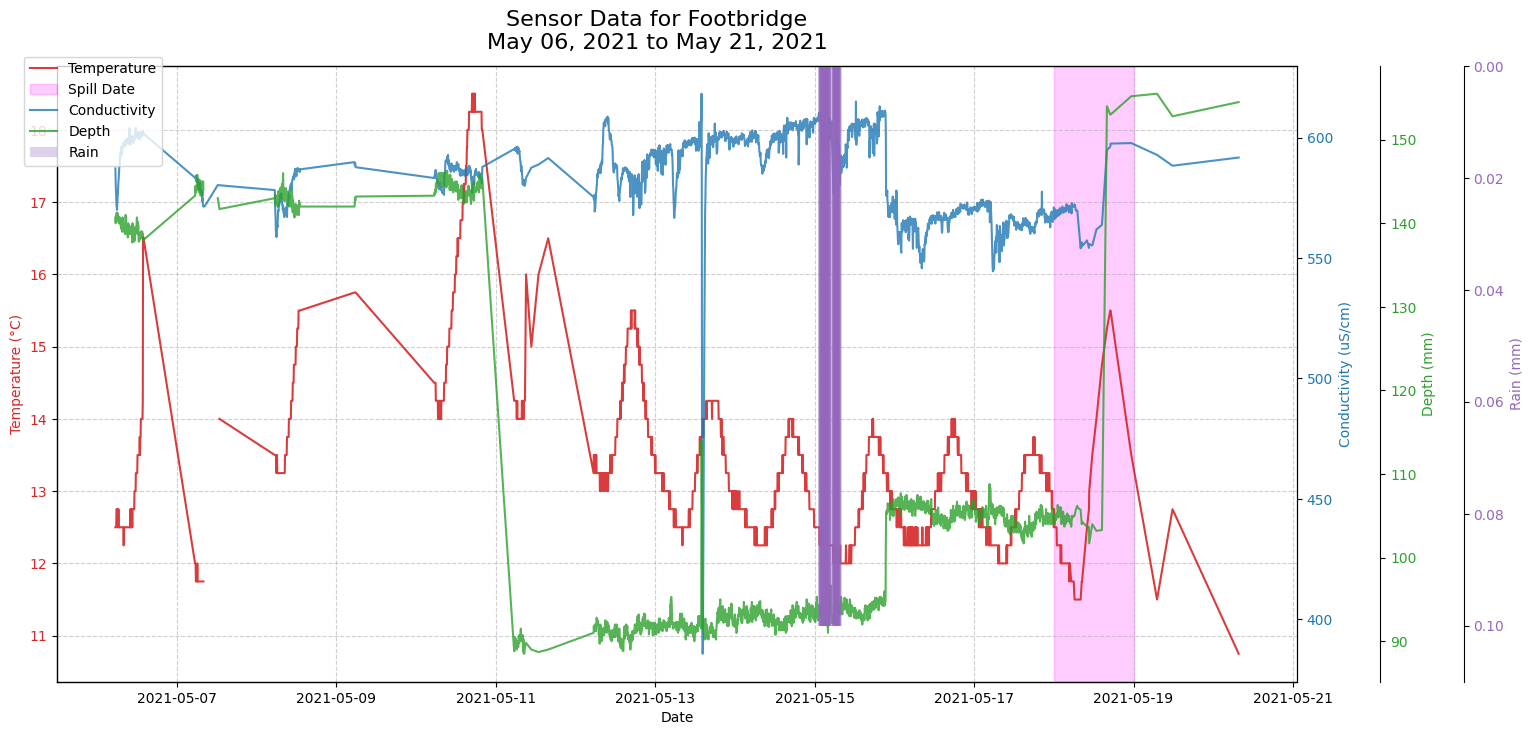

In [10]:
plot_date_range(
    df=rain_joined_MMW,
    location='footbridge',
    start_date='2021-05-06',
    end_date='2021-05-21',# This will create the magenta shaded area
    spill_event = '2021-05-18'
)

label spill/normal data

In [11]:
import pandas as pd

def label_events(df):
    """
    Creates a new 'event' column to label data based on predefined time windows.

    - 1: Spill
    - 0: Clean
    - -1: Anomaly/Exclude
    """
    # Ensure datetime column is in the correct format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Initialize the event column with a default "clean" label
    df['event'] = 0

    # Define the time windows
    # Note: Corrected the end date for the anomaly
    event_windows = {
        'spill': ('2021-05-18 08:30', '2021-05-21 18:50'),
        'anomaly': ('2021-05-13 14:00', '2021-05-13 15:10'),
        'confirmed_clean': ('2021-05-06 09:30', '2021-05-18 00:15')
    }

    # Apply labels based on the windows
    spill_start, spill_end = pd.to_datetime(event_windows['spill'])
    anomaly_start, anomaly_end = pd.to_datetime(event_windows['anomaly'])

    df.loc[(df['datetime'] >= spill_start) & (df['datetime'] <= spill_end), 'event'] = 1
    df.loc[(df['datetime'] >= anomaly_start) & (df['datetime'] <= anomaly_end), 'event'] = -1

    print("Data labeling complete.")
    print(df['event'].value_counts())
    return df
labeled_df_spill_1 = label_events(rain_joined_MMW)

Data labeling complete.
event
 0    386982
-1        30
 1        16
Name: count, dtype: int64


Feature Engineering

In [12]:
## MODIFIED FEATURE ENGINEERING FUNCTION ##

def create_features(df, feature_cols, horizon=1, window_sizes=[3, 6, 12, 24]):
    """
    Engineers time-series features with a prediction horizon.
    """
    print(f"Creating features with a horizon of {horizon} steps...")
    df_features = df.copy()
    df_features = df_features.sort_values(['location', 'datetime'])

    # Group once to apply shifts efficiently
    grouped = df_features.groupby('location')

    for col in feature_cols:
        # Shift the original column by the horizon first
        series = grouped[col].shift(horizon)
        for window in window_sizes:
            # All features are now calculated on the shifted series
            df_features[f'{col}_lag_{window}'] = grouped[col].shift(window + horizon)
            rolling_window = series.rolling(window=window)
            df_features[f'{col}_roll_mean_{window}'] = rolling_window.mean()
            df_features[f'{col}_roll_std_{window}'] = rolling_window.std()

    # Important: Re-align index if it was changed by rolling operations
    df_features = df_features.reset_index(drop=True)
    return df_features

Making Regresiions normal behvioar

In [ ]:
# Ensure featured_df exists before the training example
if 'featured_df' not in globals():
    feature_cols = ['temperature','depth','BaroPres','SolRad_Avg','rain_mm','Temp2m_Avg','WndSpd']
    featured_df = create_features(labeled_df_spill_1, feature_cols, horizon=1)
    featured_df.dropna(inplace=True)


In [ ]:
from sklearn.linear_model import Ridge

def train_sensor_model(df, feature_cols, target_col='conductivity'):
    """
    Trains a model to predict normal sensor values using only clean data.
    """
    print(f"Training a model to predict normal '{target_col}' values...")

    # Train ONLY on data labeled as 'clean' (event == 0)
    clean_df = df[df['event'] == 0].dropna(subset=feature_cols + [target_col])

    X_train = clean_df[feature_cols]
    y_train = clean_df[target_col]

    # A simple Ridge regression model is fast and effective
    sensor_model = Ridge(alpha=1.0)
    sensor_model.fit(X_train, y_train)

    print("Sensor prediction model trained.")
    return sensor_model

# --- How to use it ---
# # Define predictors for your sensor model
sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
# # Train the model
conductivity_model = train_sensor_model(featured_df, sensor_model_features)
# # Use it to predict expected values for the WHOLE dataset
all_predictions = conductivity_model.predict(featured_df[sensor_model_features])
featured_df['predicted_conductivity'] = all_predictions

optuna objective function

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import f1_score
import optuna

def objective(trial, df):
    """
    A new, more advanced objective function for Optuna to optimize.
    """
    # --- 1. Define the search space for our new parameters ---
    horizon = trial.suggest_int('horizon', 1, 12) # e.g., 1 to 12 steps (5 to 60 minutes)
    threshold_multiplier = trial.suggest_float('threshold_multiplier', 1.5, 5.0)

    # --- Original hyperparameters ---
    n_components = trial.suggest_int('n_components', 5, 20)
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)

    # --- 2. Create features using the suggested horizon ---
    feature_columns = ['conductivity', 'depth', 'temperature', 'rain_mm']
    featured_df = create_features(df, feature_columns, horizon=horizon)
    featured_df.dropna(inplace=True) # Drop NaNs from feature creation

    # --- 3. Create the sensor anomaly feature ---
    sensor_model_features = ['temperature', 'depth', 'rain_mm']
    target_sensor = 'conductivity'

    # (For speed, you could pre-train this model once outside the loop)
    sensor_model = train_sensor_model(featured_df, sensor_model_features, target_col=target_sensor)
    predicted_values = sensor_model.predict(featured_df[sensor_model_features])
    
    # Calculate the error (residual)
    error = (featured_df[target_sensor] - predicted_values).abs()
    error_std = error.std() # Standard deviation of the error

    # Flag anomalies based on the optimized threshold
    featured_df['sensor_anomaly'] = (error > (error_std * threshold_multiplier)).astype(int)

    # --- 4. Prepare data for the final spill classification model ---
    model_df = featured_df[featured_df['event'] != -1].copy()
    
    y = model_df['event']
    # Add our new 'sensor_anomaly' feature to the model's inputs
    X = model_df.drop(columns=['datetime', 'location', 'event'])

    # --- 5. Build and evaluate the final pipeline ---
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_components)),
        ('model', LogisticRegression(C=C, random_state=42, solver='liblinear'))
    ])

    pipeline.fit(X, y)
    preds = pipeline.predict(X)
    score = f1_score(y, preds, average='weighted')

    return score

# --- How to Run It ---
# # Assume 'labeled_df' is your initial dataframe with event labels
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, labeled_df_spill_1), n_trials=3) # Increase trials for more complex search

print(f"\nBest trial score: {study.best_value}")
print(f"Best trial params: {study.best_params}")

[I 2025-08-12 15:13:00,809] A new study created in memory with name: no-name-40f24eee-740f-4391-a15c-6e8b21f431f6


Creating features with a horizon of 7 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 15:13:03,385] Trial 0 finished with value: 0.9999273785052668 and parameters: {'horizon': 7, 'threshold_multiplier': 2.016598419086251, 'n_components': 9, 'C': 0.04138620720966292}. Best is trial 0 with value: 0.9999273785052668.


Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 15:13:08,112] Trial 1 finished with value: 0.9999628591050816 and parameters: {'horizon': 11, 'threshold_multiplier': 3.3881921719297496, 'n_components': 18, 'C': 12.665834530495125}. Best is trial 1 with value: 0.9999628591050816.


Creating features with a horizon of 6 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.


[I 2025-08-12 15:13:11,181] Trial 2 finished with value: 0.9999273811421119 and parameters: {'horizon': 6, 'threshold_multiplier': 2.840782904641962, 'n_components': 19, 'C': 0.02574166508636129}. Best is trial 1 with value: 0.9999628591050816.



Best trial score: 0.9999628591050816
Best trial params: {'horizon': 11, 'threshold_multiplier': 3.3881921719297496, 'n_components': 18, 'C': 12.665834530495125}


plot results

Using best parameters found by Optuna:
{'horizon': 11, 'threshold_multiplier': 3.3881921719297496, 'n_components': 18, 'C': 12.665834530495125}

Step 1: Re-creating dataset with optimal features...
Creating features with a horizon of 11 steps...
Training a model to predict normal 'conductivity' values...
Sensor prediction model trained.
Step 2: Training the final model...
Final model is trained.
Step 3: Making predictions and generating plot...
Generating plot...


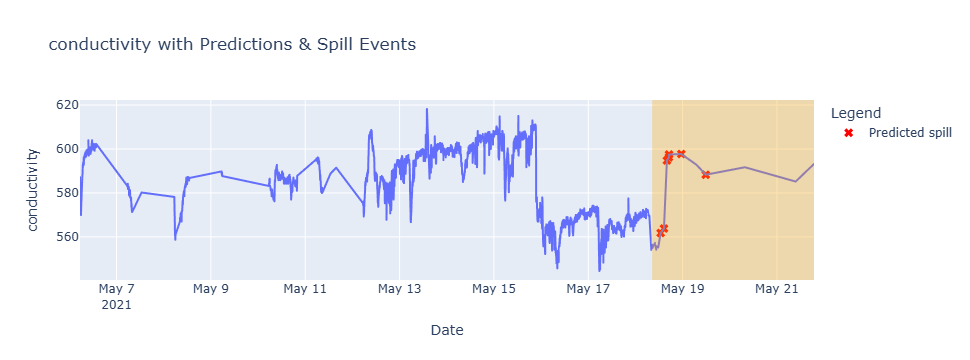

In [18]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Ridge
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
# Assume 'study' and your initial 'labeled_df_spill_1' DataFrame are loaded.

# --- 1. Get the Best Parameters ---
best_params = study.best_params
print("Using best parameters found by Optuna:")
print(best_params)

# --- 2. Re-build Your Dataset with the Best Parameters ---
print("\nStep 1: Re-creating dataset with optimal features...")
# Use the feature engineering function with the best horizon
feature_columns = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
featured_df = create_features(labeled_df_spill_1, feature_columns, horizon=best_params['horizon'])
featured_df.dropna(inplace=True)

# Create the sensor anomaly feature with the best threshold
sensor_model_features = ['temperature', 'depth', 'BaroPres', 'SolRad_Avg', 'rain_mm','Temp2m_Avg','WndSpd']
target_sensor = 'conductivity'
sensor_model = train_sensor_model(featured_df, sensor_model_features, target_col=target_sensor)
predicted_values = sensor_model.predict(featured_df[sensor_model_features])
error = (featured_df[target_sensor] - predicted_values).abs()
error_std = error.std()
featured_df['sensor_anomaly'] = (error > (error_std * best_params['threshold_multiplier'])).astype(int)

# --- 3. Train the Final Model ---
print("Step 2: Training the final model...")
# Prepare the final training data, excluding anomalies
model_df = featured_df[featured_df['event'] != -1].copy()
y = model_df['event']
X = model_df.drop(columns=['datetime', 'location', 'event'])

# Build the final pipeline with the best PCA and C values
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=best_params['n_components'])),
    ('model', LogisticRegression(C=best_params['C'], random_state=42, solver='liblinear'))
])

final_pipeline.fit(X, y)
print("Final model is trained.")

# --- 4. Make Predictions & Plot ---
# --- 4. Make Predictions & Plot (Corrected) ---
print("Step 3: Making predictions and generating plot...")

# Make predictions on the entire dataset to visualize
all_predictions = final_pipeline.predict(X)

# Create the results DataFrame for plotting
results_df = model_df.copy()
results_df['predicted_event'] = all_predictions

## THIS IS THE FIX ##
# Rename the 'event' column to 'true_event' to match what the plot function expects
results_df.rename(columns={'event': 'true_event'}, inplace=True)

# Now, call the plotting function with the corrected results_df
print("Generating plot...")
plot_model_predictions(
    df=results_df,
    location='footbridge', # Or the location you're interested in
    start_date='2021-05-06',
    end_date='2021-05-22',
    sensor='conductivity'
)

# Spill 2

In [ ]:
# Define the start and end timestamps
start_date = '2023-02-13 12:55'
end_date = '2023-06-15 3:40'

# Filter the DataFrame
filtered_df_MMW = rain_joined_MMW[
    (rain_joined_MMW['location'] == 'grinnel') &
    (rain_joined_MMW['datetime'].between(start_date, end_date))
]

# Display the first few rows of the result
filtered_df_MMW.head(2)

In [ ]:
plot_date_range(
    df=rain_joined_MMW,
    location='grinnel',
    start_date='2023-01-01',
    end_date='2023-07-21',# This will create the magenta shaded area
    spill_event = '2023-06-14'
)

In [ ]:
import pandas as pd

def label_events(df):
    """
    Creates a new 'event' column to label data based on predefined time windows.

    - 1: Spill
    - 0: Clean
    - -1: Anomaly/Exclude
    """
    # Ensure datetime column is in the correct format
    df['datetime'] = pd.to_datetime(df['datetime'])

    # Initialize the event column with a default "clean" label
    df['event'] = 0

    # Define the time windows
    # Note: Corrected the end date for the anomaly
    event_windows = {
        'spill': ('2023-06-14 12:55', '2023-06-15 3:40'),
        'confirmed_clean': ('2023-02-013 01:30', '2023-06-06 00:15')
    }

    # Apply labels based on the windows
    spill_start, spill_end = pd.to_datetime(event_windows['spill'])
    #anomaly_start, anomaly_end = pd.to_datetime(event_windows['anomaly'])

    df.loc[(df['datetime'] >= spill_start) & (df['datetime'] <= spill_end), 'event'] = 1
    #df.loc[(df['datetime'] >= anomaly_start) & (df['datetime'] <= anomaly_end), 'event'] = -1

    print("Data labeling complete.")
    print(df['event'].value_counts())
    return df
labeled_df_spill_1 = label_events(rain_joined_MMW)

In [ ]:
# --- How to Run It ---
# # Assume 'labeled_df' is your initial dataframe with event labels
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, labeled_df_spill_1), n_trials=3) # Increase trials for more complex search

print(f"\nBest trial score: {study.best_value}")
print(f"Best trial params: {study.best_params}")